# PROJECT 1 - PART 2

## 0 - imports

In [314]:
from pathlib import Path
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
from tabulate import tabulate
from captum.attr import IntegratedGradients
import torch
import random

## 1 - Q1 Exploratory Data Analysis

### 1.1 - loading data

In [315]:
train = Path("datasets/chest_xray/train")
val = Path("datasets/chest_xray/val")
test = Path("datasets/chest_xray/test")
def load_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)  # Load as grayscale

    # If you want to resize the image to a specific size, you can do it here
    # Example:
    image = cv2.resize(image, (224,224))

    return image

def create_dataframe(directory):
    # path to the normal and pneumonia sub-directories
    normal_cases_dir = directory / 'NORMAL'
    pneumonia_cases_dir = directory / 'PNEUMONIA'

    # list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    data = []

    # set label for normal cases to be 0
    for img in normal_cases:
        data.append((load_image(img), 0))

    # set label for pneumonia cases to be 1
    for img in pneumonia_cases:
        data.append((load_image(img), 1))

    # shuffle otherwise all 0 and then all 1
    df = pd.DataFrame(data, columns=['image', 'label'])
    df = df.sample(frac=1.).reset_index(drop=True)
    
    return df

# Rest of your code remains the same
train_df = create_dataframe(train)
val_df = create_dataframe(val)
test_df = create_dataframe(test)

print("Train Data:")
print(train_df.head())

print("\nVal Data:")
print(val_df.head())

print("\nTest Data:")
print(test_df.head())

Train Data:
                                               image  label
0  [[31, 30, 29, 29, 28, 26, 25, 22, 21, 47, 54, ...      1
1  [[109, 110, 113, 115, 133, 139, 134, 135, 130,...      1
2  [[48, 49, 47, 48, 51, 51, 54, 53, 51, 51, 52, ...      1
3  [[6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 6, 5, 6, 6,...      1
4  [[52, 58, 63, 71, 72, 80, 81, 84, 91, 95, 103,...      0

Val Data:
                                               image  label
0  [[2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 3, 116, 85, 0,...      1
1  [[0, 0, 0, 6, 10, 16, 23, 28, 40, 52, 68, 73, ...      1
2  [[0, 0, 0, 0, 0, 0, 1, 4, 3, 5, 9, 8, 13, 12, ...      0
3  [[150, 4, 183, 65, 56, 64, 69, 71, 129, 145, 1...      0
4  [[16, 19, 20, 19, 20, 26, 28, 30, 33, 32, 39, ...      1

Test Data:
                                               image  label
0  [[32, 38, 32, 33, 31, 31, 28, 32, 28, 29, 25, ...      0
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 254, 206, 0...      1
2  [[147, 139, 143, 146, 143, 145, 144, 143, 172,...      0
3  [[

In [316]:
# Separate train data into X_train and y_train
X_train = train_df['image']
y_train = train_df['label']

# Separate validation data into X_val and y_val
X_val = val_df['image']
y_val = val_df['label']

# Separate test data into X_test and y_test
X_test = test_df['image']
y_test = test_df['label']

### 1.2 - dataset exploration

In [317]:
# 0 - explore dataset dimension
def get_dataset_info(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    normal_path = os.path.join(directory, 'NORMAL')
    num_pneumonia = len(os.listdir(pneumonia_path))
    num_normal = len(os.listdir(normal_path))
    return num_pneumonia, num_normal

train_pneumonia, train_normal = get_dataset_info(train)
val_pneumonia, val_normal = get_dataset_info(val)
test_pneumonia, test_normal = get_dataset_info(test)

data = [
    ["Train set", train_pneumonia, train_normal],
    ["Validation set", val_pneumonia, val_normal],
    ["Test set", test_pneumonia, test_normal]
]

headers = ["Dataset", "PNEUMONIA", "NORMAL"]

print(tabulate(data, headers=headers, tablefmt="grid"))


+----------------+-------------+----------+
| Dataset        |   PNEUMONIA |   NORMAL |
+================+=============+==========+
| Train set      |        3875 |     1341 |
+----------------+-------------+----------+
| Validation set |           8 |        8 |
+----------------+-------------+----------+
| Test set       |         390 |      234 |
+----------------+-------------+----------+


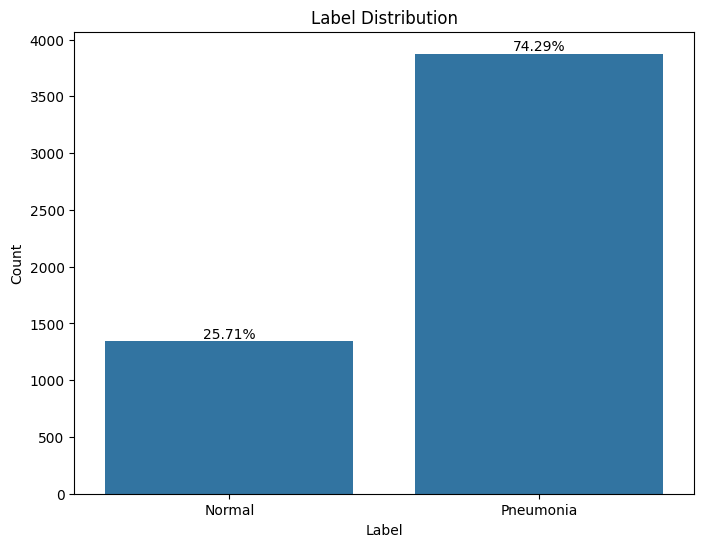

In [318]:
# 1 - label distribution
label_counts = train_df['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
ax=sb.countplot(x='label', data=train_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Pneumonia'])
for i,p in enumerate(ax.patches):
        height = p.get_height()
        if height > 0: 
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 30,f'{label_counts[i]:.2f}%',
                    ha="center")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'read'

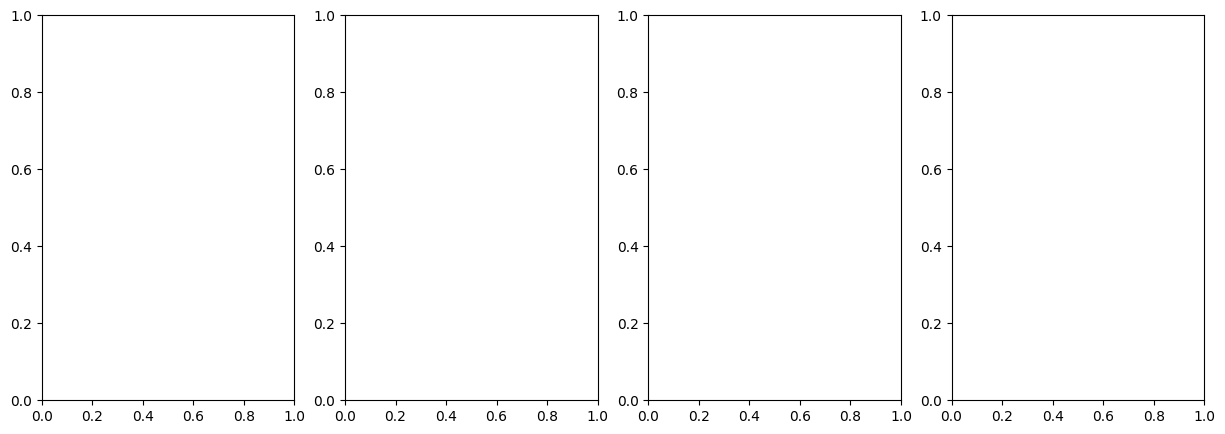

In [319]:
# 3 - plot samples
def plot_examples(df, label, num_examples=4):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    filtered_df = df[df['label'] == label].sample(num_examples)
    for i, (_, row) in enumerate(filtered_df.iterrows()):
        img_path = row['image']
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_examples(train_df, label=0)
plot_examples(train_df, label=1)

#### REPORT:
- I can't see any difference between normal and pneumonia xrays
- data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. To increase the number of training examples, we can use data augmentation


### 1.3 - data preprocessing

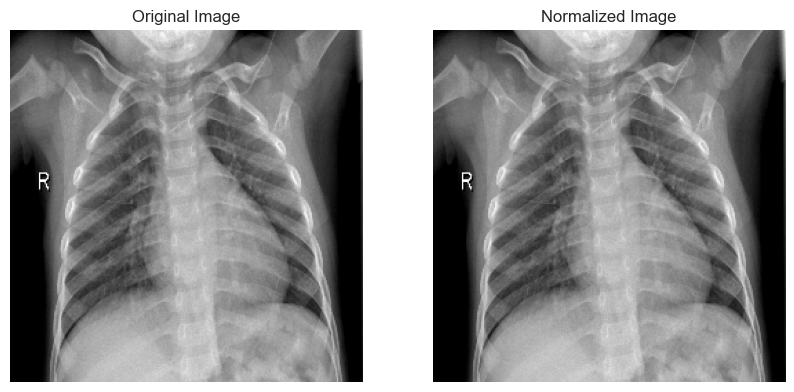

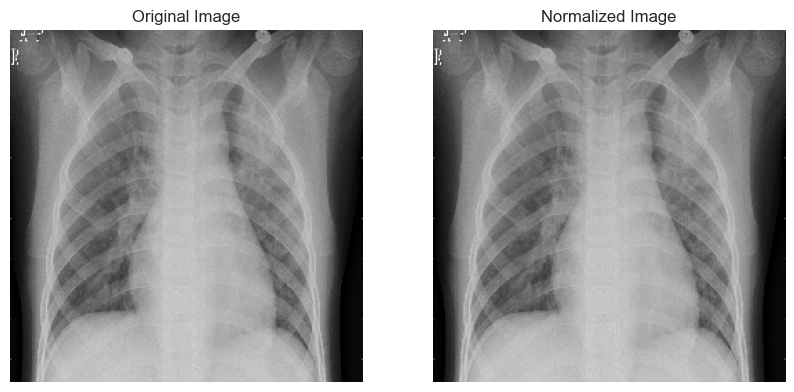

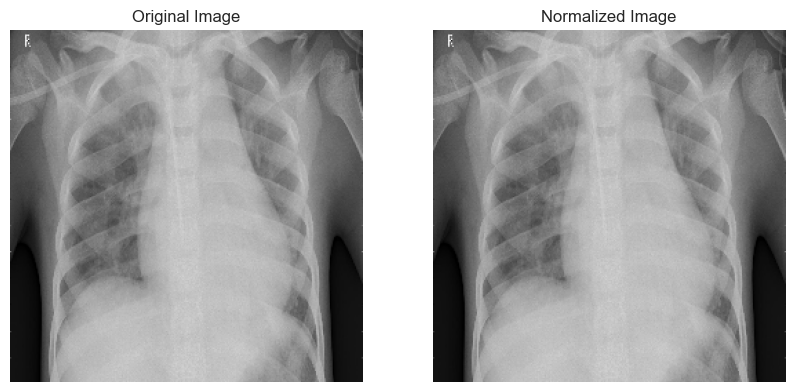

In [ ]:
# 0 - greyscale normalization (needed??)
def read_and_normalize_image(image_path, target_size=(256, 256)):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0
    return img_resized, img_normalized

# work in batches of data
def image_generator(dataframe, batch_size=32):
    num_samples = len(dataframe)
    while True:
        dataframe = shuffle(dataframe)
        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe[offset:offset+batch_size]
            images = []
            normalized_images = []
            labels = []
            for _, row in batch_df.iterrows():
                img_path = row['image']
                img_resized, img_normalized = read_and_normalize_image(img_path)
                images.append(img_resized)
                normalized_images.append(img_normalized)
            yield np.array(images), np.array(normalized_images), np.array(labels)

# Define batch size
batch_size = 32 

train_generator = image_generator(X_train, batch_size=batch_size)
val_generator = image_generator(X_val, batch_size=batch_size)
test_generator = image_generator(X_test, batch_size=batch_size)

# look at the difference
for i in range(1):
    X_batch, X_normalized_batch, y_batch = next(train_generator)
    for j in range(3):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X_batch[j], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(X_normalized_batch[j], cmap='gray')
        plt.title('Normalized Image')
        plt.axis('off')
        plt.show()


In [ ]:
img1 = 

## 2 - CNN Classifier

In [ ]:
from torch.utils.data import DataLoader, Dataset
batch_size = 32
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img = self.dataframe.iloc[idx, 0]  # Get image from dataframe
        label = self.dataframe.iloc[idx, 1]  # Get label from dataframe
        img = np.array(img, dtype=np.float32)
        return img, label

train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)
test_dataset = CustomDataset(test_df)

print(train_df.iloc[0])
print(train_dataset[0])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(train_loader))
print(train_df.shape)


image    [[60, 53, 40, 57, 65, 63, 33, 48, 25, 31, 29, ...
label                                                    1
Name: 0, dtype: object
(array([[ 60.,  53.,  40., ...,  53.,  85.,  81.],
       [ 56.,  48.,  42., ...,  80.,  61., 100.],
       [ 39.,  41.,  53., ...,  81.,  65.,  80.],
       ...,
       [ 64.,  40.,  29., ...,  75.,  81.,  76.],
       [ 64.,  40.,  29., ...,  56.,  91.,  77.],
       [ 65.,  41.,  29., ...,  51.,  77.,  88.]], dtype=float32), 1)
163
(5216, 2)


In [322]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))  # Add one dimension for channel (1 for grayscale)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")


train(model, train_loader, criterion, optimizer, device)


test(model, test_loader, criterion, device)


Epoch 1/5, Loss: 9.1964
Epoch 2/5, Loss: 0.1376
Epoch 3/5, Loss: 0.0968
Epoch 4/5, Loss: 0.0606
Epoch 5/5, Loss: 0.0719
Test Accuracy: 0.7163


In [370]:
for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            print(inputs.shape)
           
            #outputs = model(inputs.unsqueeze(1))

torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
torch.Size([32, 224, 224])
t

In [324]:
for name, layer in model.named_children():
    print(f'Layer name: {name}')
    print(layer)

Layer name: conv1
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer name: conv2
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer name: conv3
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer name: pool
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer name: fc1
Linear(in_features=100352, out_features=512, bias=True)
Layer name: fc2
Linear(in_features=512, out_features=2, bias=True)
Layer name: dropout
Dropout(p=0.5, inplace=False)


In [325]:
from PIL import Image
import torchvision.transforms as transforms


image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


def predict_class_and_score(model, image_path):

    image = Image.open(image_path)
    image_tensor = image_transforms(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        model.eval()
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = 'Normal' if predicted.item() == 0 else 'Pneumonia'
        predicted_score = torch.sigmoid(outputs).squeeze().cpu().numpy()[predicted.item()]
    return predicted_class, predicted_score


image_path = './datasets/chest_xray/train/PNEUMONIA/person1_bacteria_2.jpeg' 
predicted_class, predicted_score = predict_class_and_score(model, image_path)
print('Predicted class:', predicted_class)
print('Predicted score:', predicted_score)



Predicted class: Pneumonia
Predicted score: 0.5291541


## 3 - Integrated Gradients

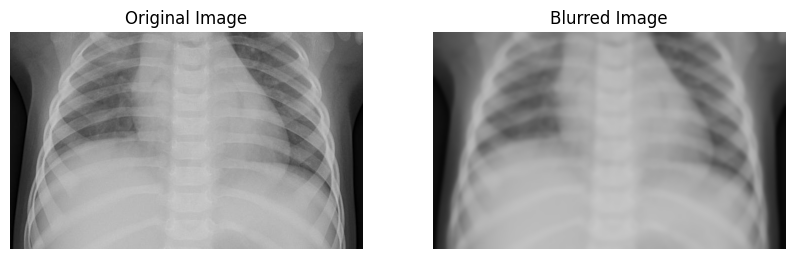

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_11951/1805961283.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_img_tensor = torch.tensor(blurred_baseline, dtype=torch.float32)


In [330]:

baseline_img = Image.open('./datasets/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
def create_blurred_baseline(image, blur_radius):
    image_np = np.array(image)
    blurred_image = cv2.GaussianBlur(image_np, (blur_radius, blur_radius), 0)
    return blurred_image
blur_radius = 21
blurred_baseline = create_blurred_baseline(baseline_img, blur_radius)

# original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(baseline_img)
plt.title('Original Image')
plt.axis('off')
# blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_baseline)
plt.title('Blurred Image')
plt.axis('off')
plt.show()



from torchvision.transforms import ToPILImage

def numpy_transforms(image):
    to_pil = ToPILImage()
    pil_image = to_pil(image)
    tensor_image = image_transforms(pil_image).unsqueeze(0)
    
    return tensor_image


blurred_baseline = numpy_transforms(blurred_baseline)

baseline_img_tensor = torch.tensor(blurred_baseline, dtype=torch.float32)



In [332]:
image = Image.open('./datasets/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')

image2 = image_transforms(image).unsqueeze(0)
image_tensor = image_transforms(image).unsqueeze(0)
image_tensor = image_tensor.to(device)
ig = IntegratedGradients(model)
attributions_ig = ig.attribute(image_tensor, baselines=baseline_img_tensor, target=1, n_steps=500)



In [333]:
print(normalized_attributions_ig.squeeze(0).detach().numpy().shape)
print( np.transpose(image2.squeeze().cpu().detach().numpy(), ( 1, 0)).shape)

(1, 224, 224)
(224, 224)


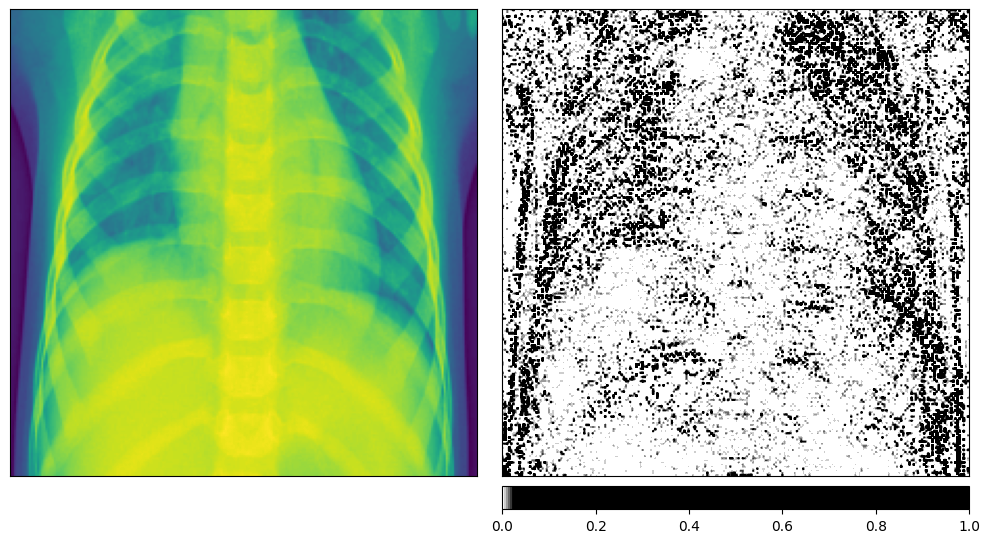

In [336]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.02, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(),(1,2,0)),
                                      image2.squeeze().cpu().detach().numpy(),
                                      methods=["original_image", "heat_map"],
                                      signs=['all', 'positive'],
                                      cmap=default_cmap,
                                      show_colorbar=True, fig_size=(10, 10), use_pyplot=True)



## 4 - GRAD-CAM

In [483]:
import cv2
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
def read_and_normalize_image(image_path, target_size=(224, 224)):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)
    img_normalized = np.float32(img_resized / 255.0)
    return img_resized, img_normalized

_,img1 = read_and_normalize_image('./datasets/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
img1 = torch.Tensor(img1).unsqueeze(0).unsqueeze(0)
target_layers = [model.conv2]
cam = GradCAM(model=model, target_layers=target_layers)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=img1, targets=targets)


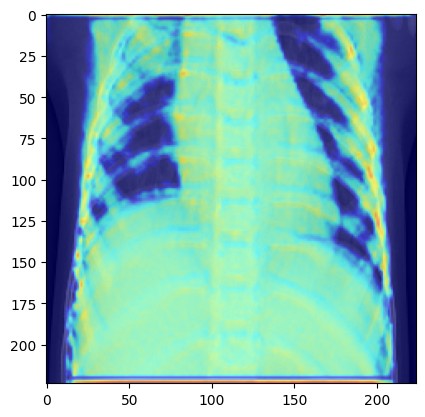

In [484]:
from PIL import Image
import numpy as np

# Open the JPEG image
def read_and_normalize_image2(image_path, target_size=(224, 224)):
    img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, target_size)
    img_normalized = np.float32(img_resized / 255.0)
    return img_resized, img_normalized


_,img2 = read_and_normalize_image2('./datasets/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')


# Convert the values to float32 and scale between 0 and 1
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img2,grayscale_cam, use_rgb=True)
model_outputs = cam.outputs
plt.imshow(visualization)


## 5 - DATA RANDOMIZATION TEST

In [ ]:

# random permutation of labels
permuted_train_df = train_df.copy()
permuted_train_df['label'] = np.random.permutation(permuted_train_df['label'])

# train again model


# compute attributions for the permuted model on the test set

# compare atrtibutions of original and permuted models
mean_abs_diff = torch.mean(torch.abs(original_attributions - permuted_attributions))
print(f'Mean Absolute Difference: {mean_abs_diff:.4f}')